# Data Collection

In [1]:
# Import libraries
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, broadcast, sum as spark_sum
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Mortality Analysis") \
    .getOrCreate()

In [3]:
# Read Parquet files into DataFrames with inferred schema
df1 = spark.read.parquet("../data/2015-data.parquet", header=True, inferSchema=True)
df2 = spark.read.parquet("../data/2014-data.parquet", header=True, inferSchema=True)
df3 = spark.read.parquet("../data/2013-data.parquet", header=True, inferSchema=True)

# Combine the DataFrames by union
df = df1.unionByName(df2).unionByName(df3)

## Defining a column maped with the causes of death for better understanding

In [5]:
# Load the cause of death codes from a JSON file
with open("../data/2015_codes.json", "r") as f:
    code_maps = json.load(f)

# Convert the "358_cause_recode" mapping to a list of tuples for easier use
cause_lookup = list(code_maps["358_cause_recode"].items())

# Create a Spark DataFrame for the lookup table
lookup_df = spark.createDataFrame(cause_lookup, ["code", "label"])

# Join the original DataFrame with the lookup DataFrame on the cause code
df_joined = df.join(
    broadcast(lookup_df),
    df["358_cause_recode"] == lookup_df["code"],
    how="left"
).drop("code")  # Drop the code column after join

# Rename the "label" column to "decoded_358_cause" for clarity
df_maped = df_joined.withColumnRenamed("label", "decoded_358_cause")

# Exploratory Data Analysis (EDA)

In [6]:
# Print the schema of the DataFrame to inspect its structure
df_maped.printSchema()

root
 |-- resident_status: double (nullable = true)
 |-- education_1989_revision: double (nullable = true)
 |-- education_2003_revision: string (nullable = true)
 |-- education_reporting_flag: double (nullable = true)
 |-- month_of_death: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- detail_age_type: double (nullable = true)
 |-- detail_age: double (nullable = true)
 |-- age_substitution_flag: string (nullable = true)
 |-- age_recode_52: double (nullable = true)
 |-- age_recode_27: double (nullable = true)
 |-- age_recode_12: double (nullable = true)
 |-- infant_age_recode_22: double (nullable = true)
 |-- place_of_death_and_decedents_status: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- day_of_week_of_death: double (nullable = true)
 |-- current_data_year: double (nullable = true)
 |-- injury_at_work: string (nullable = true)
 |-- manner_of_death: double (nullable = true)
 |-- method_of_disposition: string (nullable = true)
 |-- autopsy

In [5]:
# Print the number of rows and columns in the DataFrame
print("\nNumber of rows and columns:")
print(f"Rows: {df_maped.count()}, Columns: {len(df_maped.columns)}")


Number of rows and columns:
Rows: 7950821, Columns: 78


In [6]:
# Calculate the number of null values per column in the mapped DataFrame
null_counts = df_maped.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

# Convert the result to a dictionary for easier manipulation
null_counts = null_counts.first().asDict()

# Sort the columns by the number of nulls in descending order
top_nulls = sorted(null_counts.items(), key=lambda x: x[1], reverse=True)[:]

# Print columns with null values and their counts
for col_name, count in top_nulls:
    if count > 0:
        print(f"{col_name}: {count} nulls")

entity_condition_16: 7950821 nulls
entity_condition_17: 7950821 nulls
entity_condition_18: 7950821 nulls
entity_condition_19: 7950821 nulls
entity_condition_20: 7950821 nulls
record_condition_18: 7950821 nulls
record_condition_19: 7950821 nulls
record_condition_20: 7950821 nulls
record_condition_17: 7950820 nulls
record_condition_16: 7950818 nulls
record_condition_15: 7950801 nulls
entity_condition_15: 7950780 nulls
age_substitution_flag: 7950756 nulls
record_condition_14: 7950303 nulls
record_condition_13: 7948720 nulls
entity_condition_14: 7948368 nulls
entity_condition_13: 7945066 nulls
record_condition_12: 7944443 nulls
entity_condition_12: 7937234 nulls
record_condition_11: 7934991 nulls
entity_condition_11: 7921652 nulls
bridged_race_flag: 7917370 nulls
record_condition_10: 7914816 nulls
entity_condition_10: 7891253 nulls
infant_age_recode_22: 7880508 nulls
130_infant_cause_recode: 7880508 nulls
race_imputation_flag: 7878228 nulls
record_condition_9: 7872322 nulls
entity_conditio

## Most common age at death

In [7]:
# Group by "detail_age", count occurrences, and order by count in descending order
df_maped.groupBy("detail_age").count().orderBy("count", ascending=False).show(truncate=False)

+----------+------+
|detail_age|count |
+----------+------+
|87        |237076|
|86        |233823|
|88        |233479|
|85        |230860|
|89        |226994|
|84        |225905|
|90        |218111|
|83        |217237|
|82        |208299|
|91        |203394|
|81        |196986|
|80        |189843|
|92        |185904|
|79        |181874|
|78        |176227|
|77        |170436|
|93        |164343|
|76        |163683|
|75        |158851|
|74        |152985|
+----------+------+
only showing top 20 rows



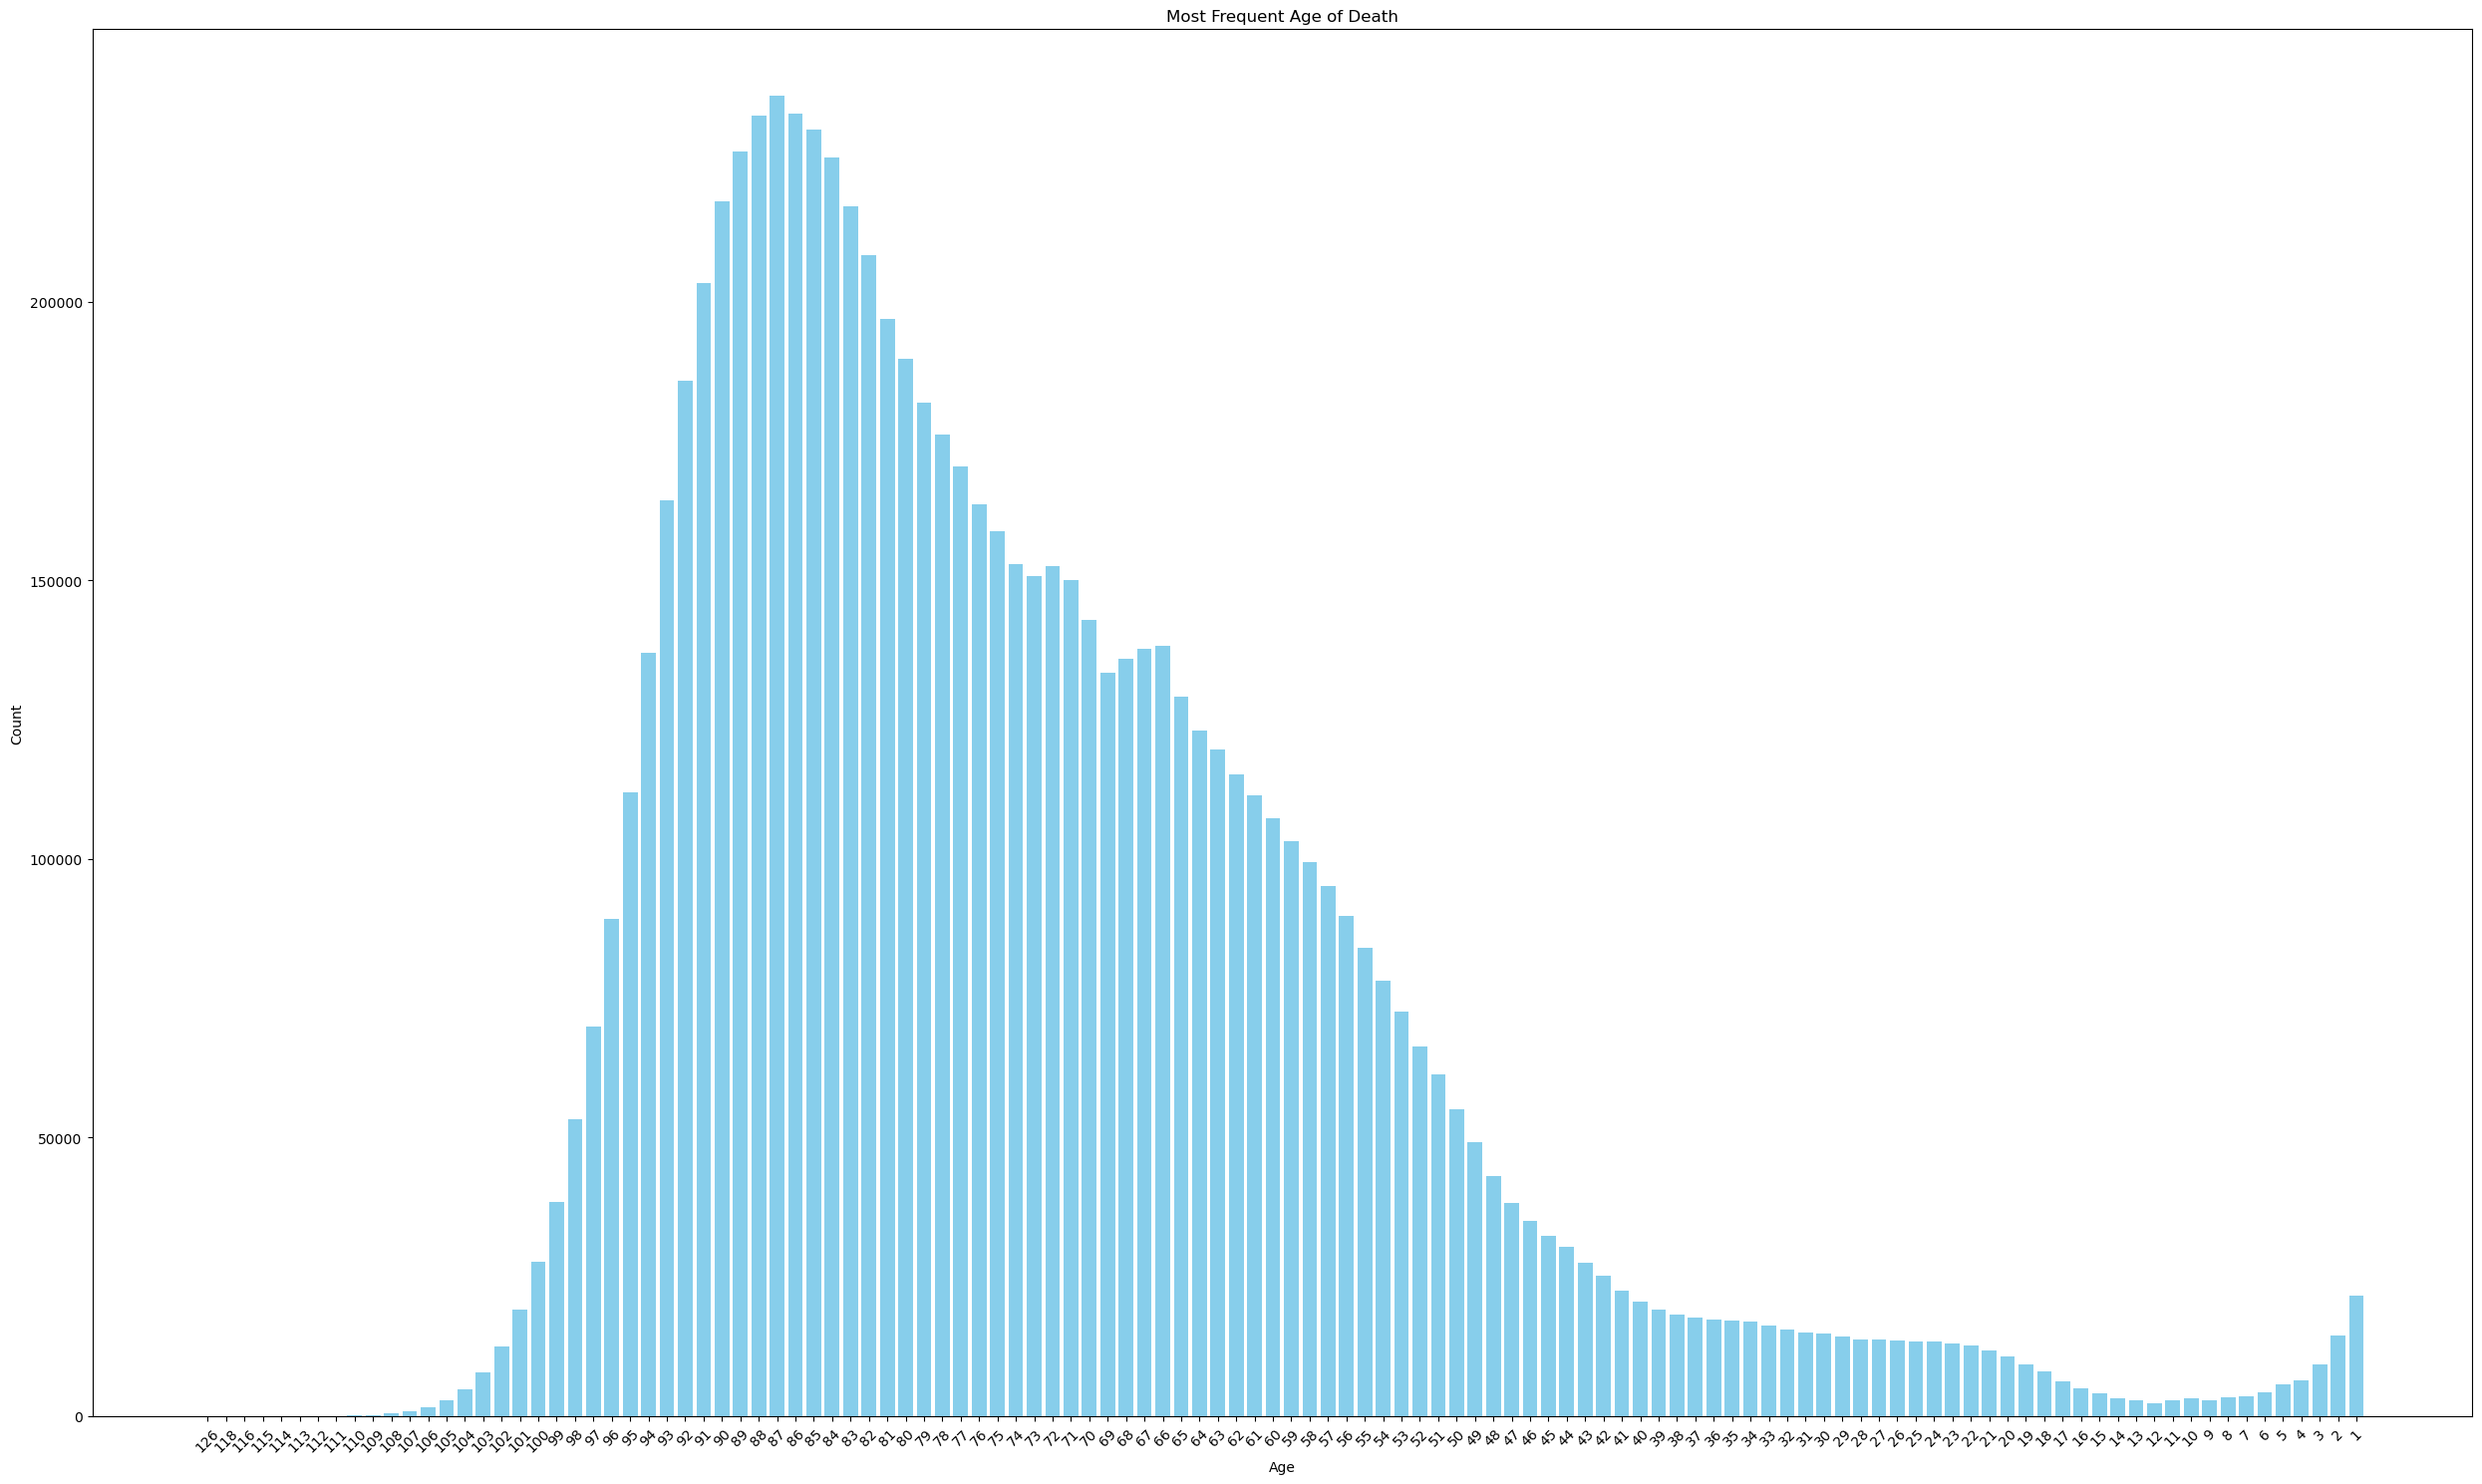

In [8]:
# Filter out ages greater than 126
filtered_ages = df_maped.filter(df_maped["detail_age"] <= 126)

# Group by "detail_age", count occurrences, and order by age in descending order
ages = filtered_ages.groupBy("detail_age").count().orderBy("detail_age", ascending=False).collect()

# Extract age categories and their counts for plotting
categories = [str(row["detail_age"]) for row in ages]
counts = [row['count'] for row in ages]

# Plot the bar chart
plt.figure(figsize=(25, 15))
plt.bar(categories, counts, color="skyblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Most Frequent Age of Death")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Age at death between men and women

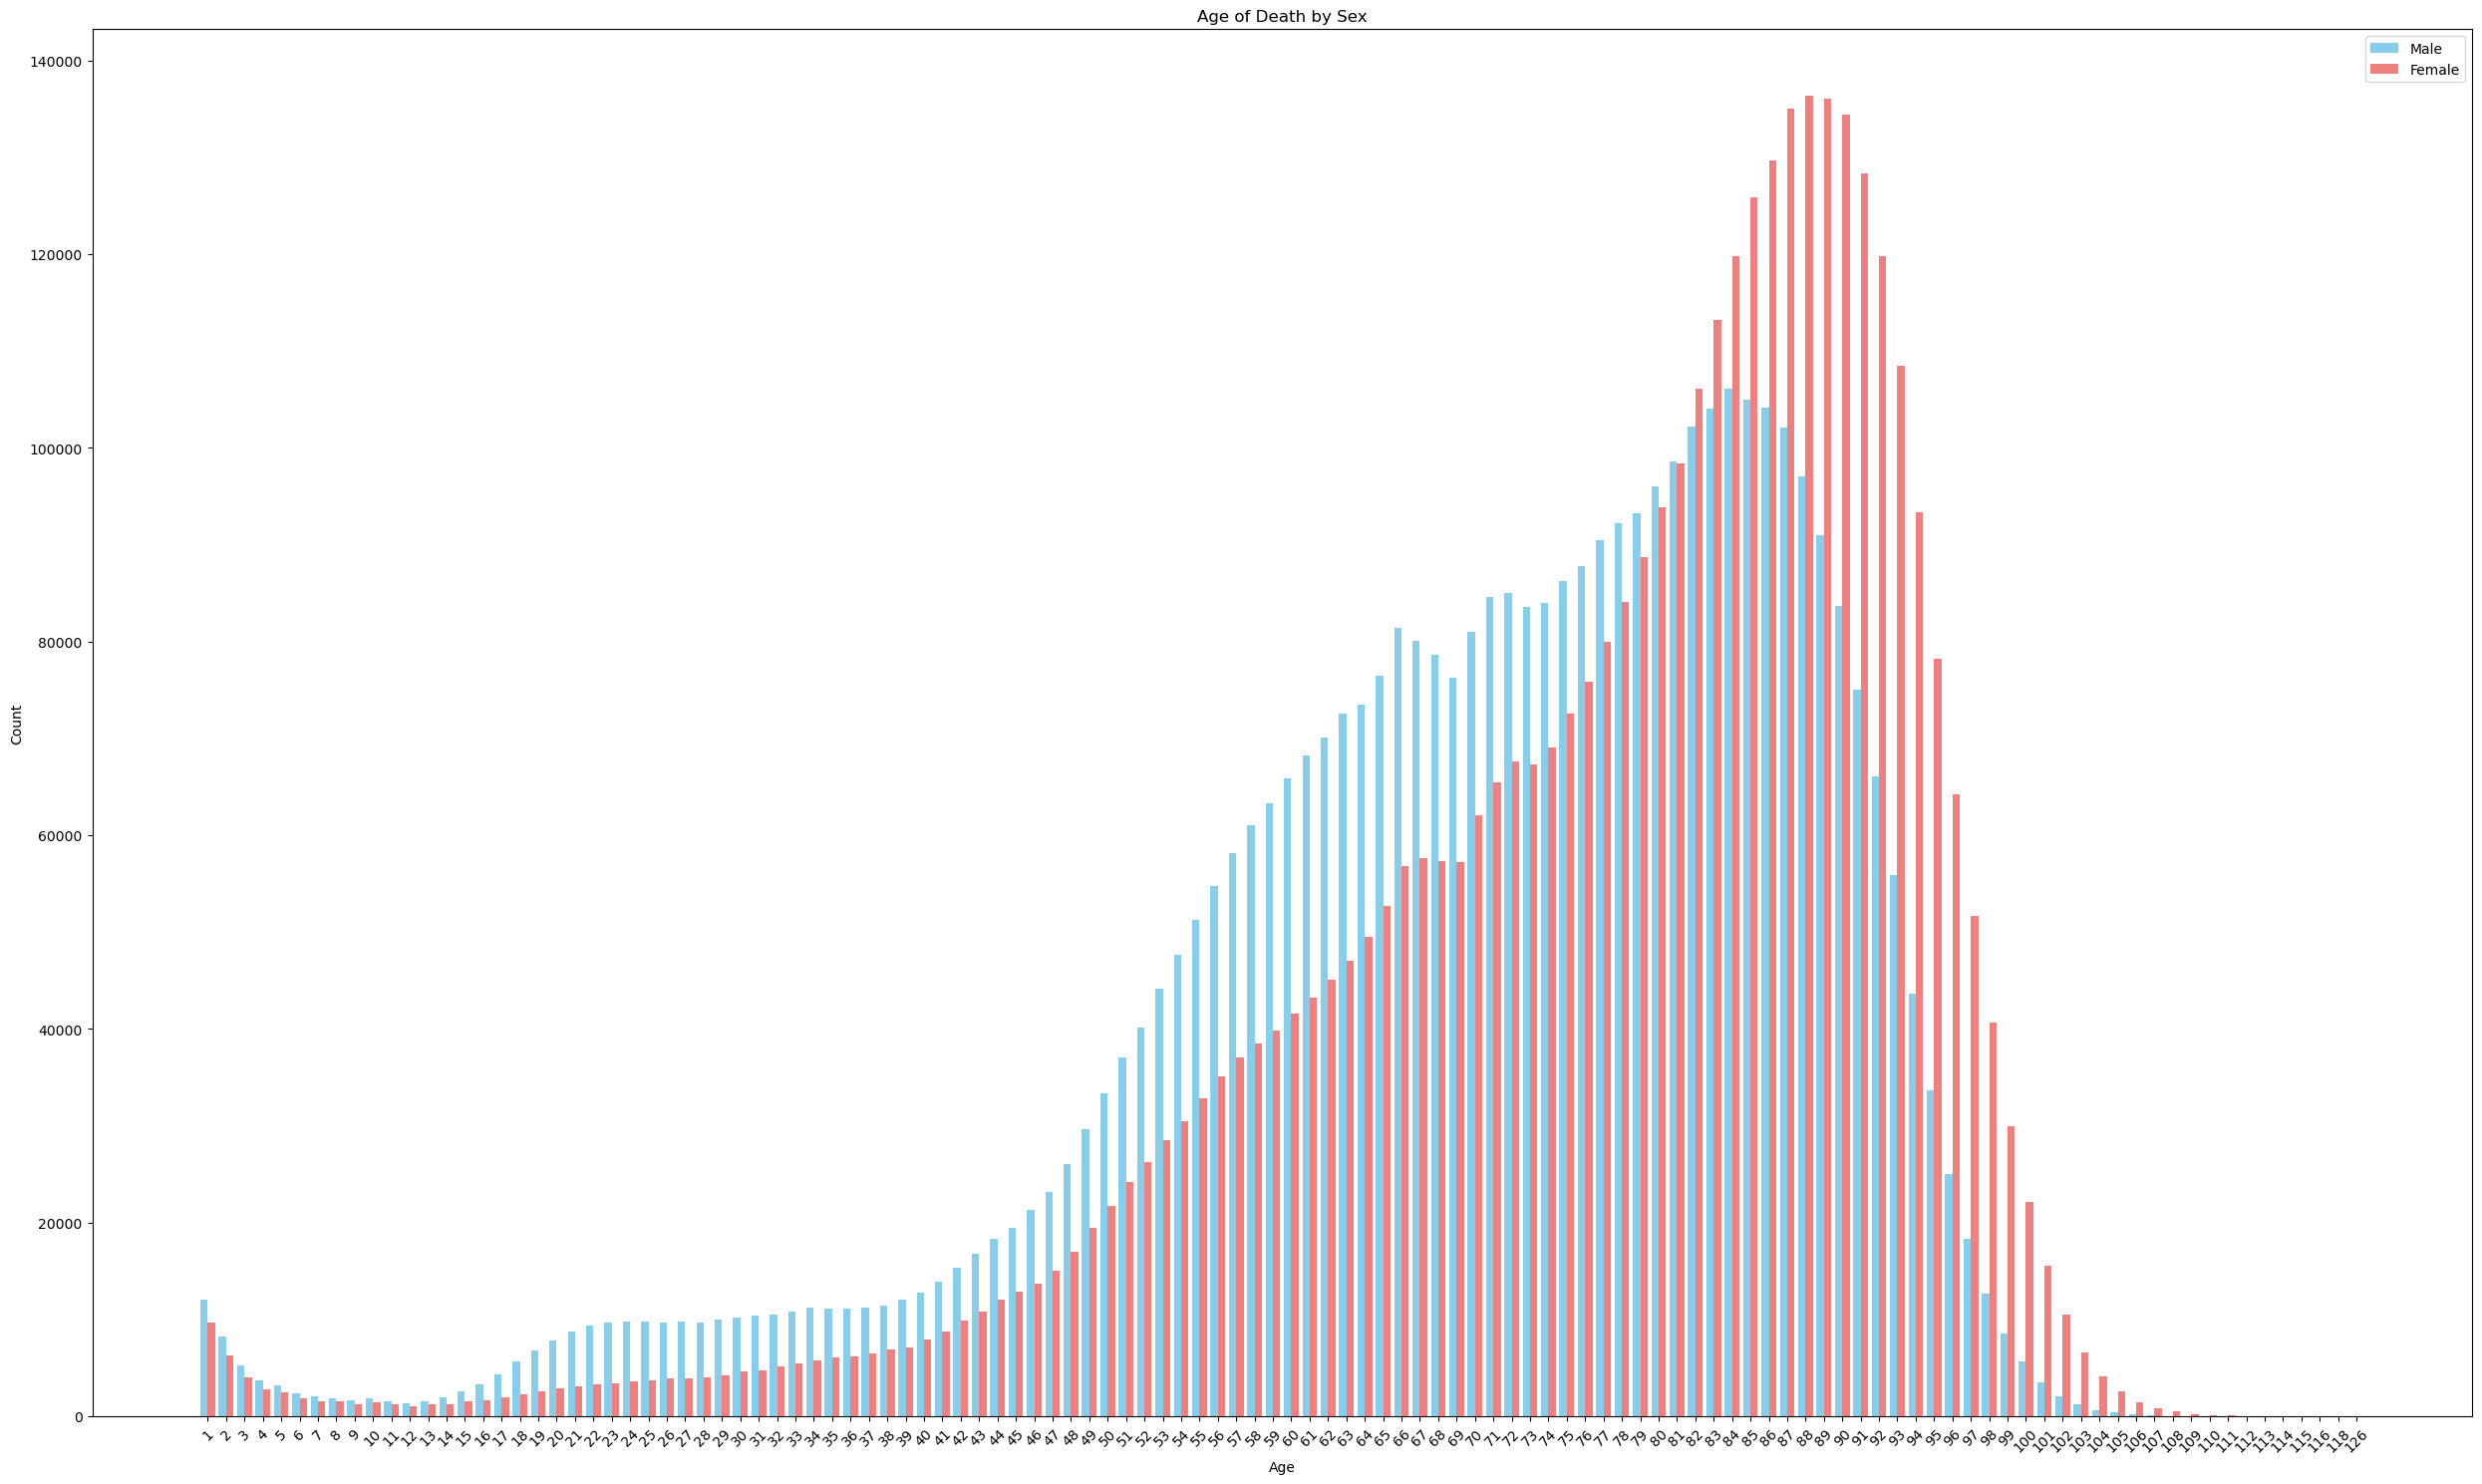

In [9]:
# Group data by "detail_age" and "sex", and count occurrences
grouped_age_sex = (
    filtered_ages.groupBy("detail_age", "sex")
    .count()
    .orderBy("detail_age", ascending=True)
    .collect()
)

# Initialize sets and dictionaries to store counts
age_sex_set = set()
male_counts = {}
female_counts = {}

# Organize counts by age and sex
for row in grouped_age_sex:
    age = row["detail_age"]
    sex = row["sex"]
    count = row["count"]
    age_sex_set.add(age)
    if sex == "M":
        male_counts[age] = count
    elif sex == "F":
        female_counts[age] = count

# Sort ages and extract male and female counts
ages_sex = sorted(age_sex_set)
male_values = [male_counts.get(age, 0) for age in ages_sex]
female_values = [female_counts.get(age, 0) for age in ages_sex]

# Set up positions and labels for the bar chart
bar_width = 0.4
x_positions = list(range(len(ages_sex)))
x_labels = [str(age) for age in ages_sex]

# Plot the bar chart for male and female counts by age
plt.figure(figsize=(25, 15))
plt.bar([x - bar_width/2 for x in x_positions], male_values, width=bar_width, label="Male", color="skyblue")
plt.bar([x + bar_width/2 for x in x_positions], female_values, width=bar_width, label="Female", color="lightcoral")

# Add labels, title, and legend
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age of Death by Sex")
plt.xticks(x_positions, x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Most common causes of death

In [10]:
# Group by "358_cause_recode" and "decoded_358_cause", count occurrences, and get the top 20 causes
most_causes = df_maped.groupBy("358_cause_recode", "decoded_358_cause").count().orderBy("count", ascending=False).limit(20)

most_causes.show(truncate=False)

+----------------+---------------------------------------------------------------------------------------+------+
|358_cause_recode|decoded_358_cause                                                                      |count |
+----------------+---------------------------------------------------------------------------------------+------+
|215             |All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)                    |565374|
|93              |Of trachea, bronchus and lung (C33-C34)                                                |466070|
|267             |Other chronic obstructive pulmonary disease (J44)                                      |412885|
|175             |Organic dementia (F01,F03)                                                             |400474|
|211             |Acute myocardial infarction (I21-I22)                                                  |345565|
|189             |Alzheimer=s disease (G30)                                             

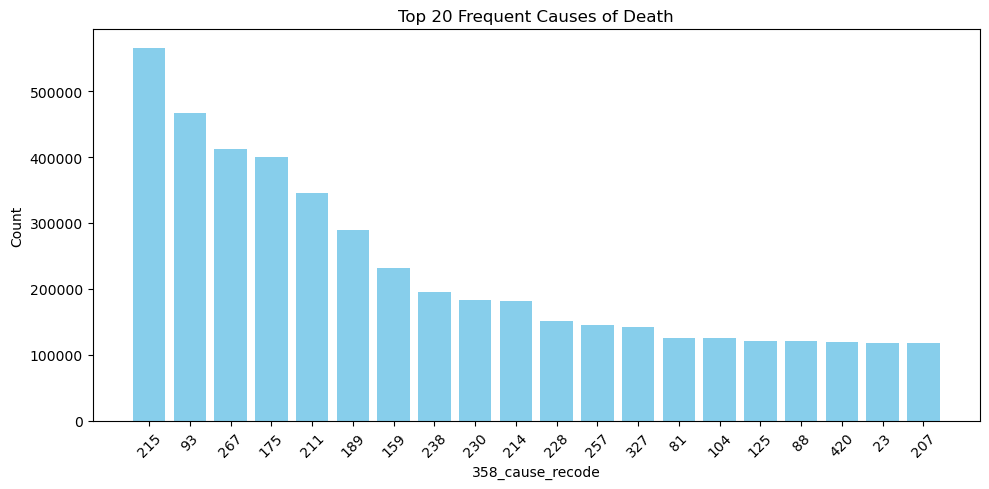

In [11]:
# Extract cause codes and their counts from the top 20 causes DataFrame
categories = [str(row["358_cause_recode"]) for row in most_causes.collect()]
counts = [row["count"] for row in most_causes.collect()]

# Plot a bar chart for the top 20 most frequent causes
plt.figure(figsize=(10, 5))
plt.bar(categories, counts, color="skyblue")
plt.xlabel("358_cause_recode")
plt.ylabel("Count")
plt.title("Top 20 Frequent Causes of Death")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Group by cause code, decoded cause, and sex, and count occurrences
grouped_causes_sex = df_maped.groupBy("358_cause_recode", "decoded_358_cause", "sex").count()

# Extract the top causes from the previous DataFrame
top_causes = [row["358_cause_recode"] for row in most_causes.collect()]

# Filter the grouped causes to include only the top causes, then order by count
grouped_causes_sex_filtered = grouped_causes_sex.filter(col("358_cause_recode").isin(top_causes)).orderBy("count", ascending=False)

# Display the filtered and sorted DataFrame
grouped_causes_sex_filtered.show(truncate=False)

+----------------+-------------------------------------------------------------------+---+------+
|358_cause_recode|decoded_358_cause                                                  |sex|count |
+----------------+-------------------------------------------------------------------+---+------+
|215             |All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)|M  |313821|
|175             |Organic dementia (F01,F03)                                         |F  |271103|
|93              |Of trachea, bronchus and lung (C33-C34)                            |M  |254570|
|215             |All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)|F  |251553|
|267             |Other chronic obstructive pulmonary disease (J44)                  |F  |218211|
|93              |Of trachea, bronchus and lung (C33-C34)                            |F  |211500|
|189             |Alzheimer=s disease (G30)                                          |F  |201020|
|211             |Ac

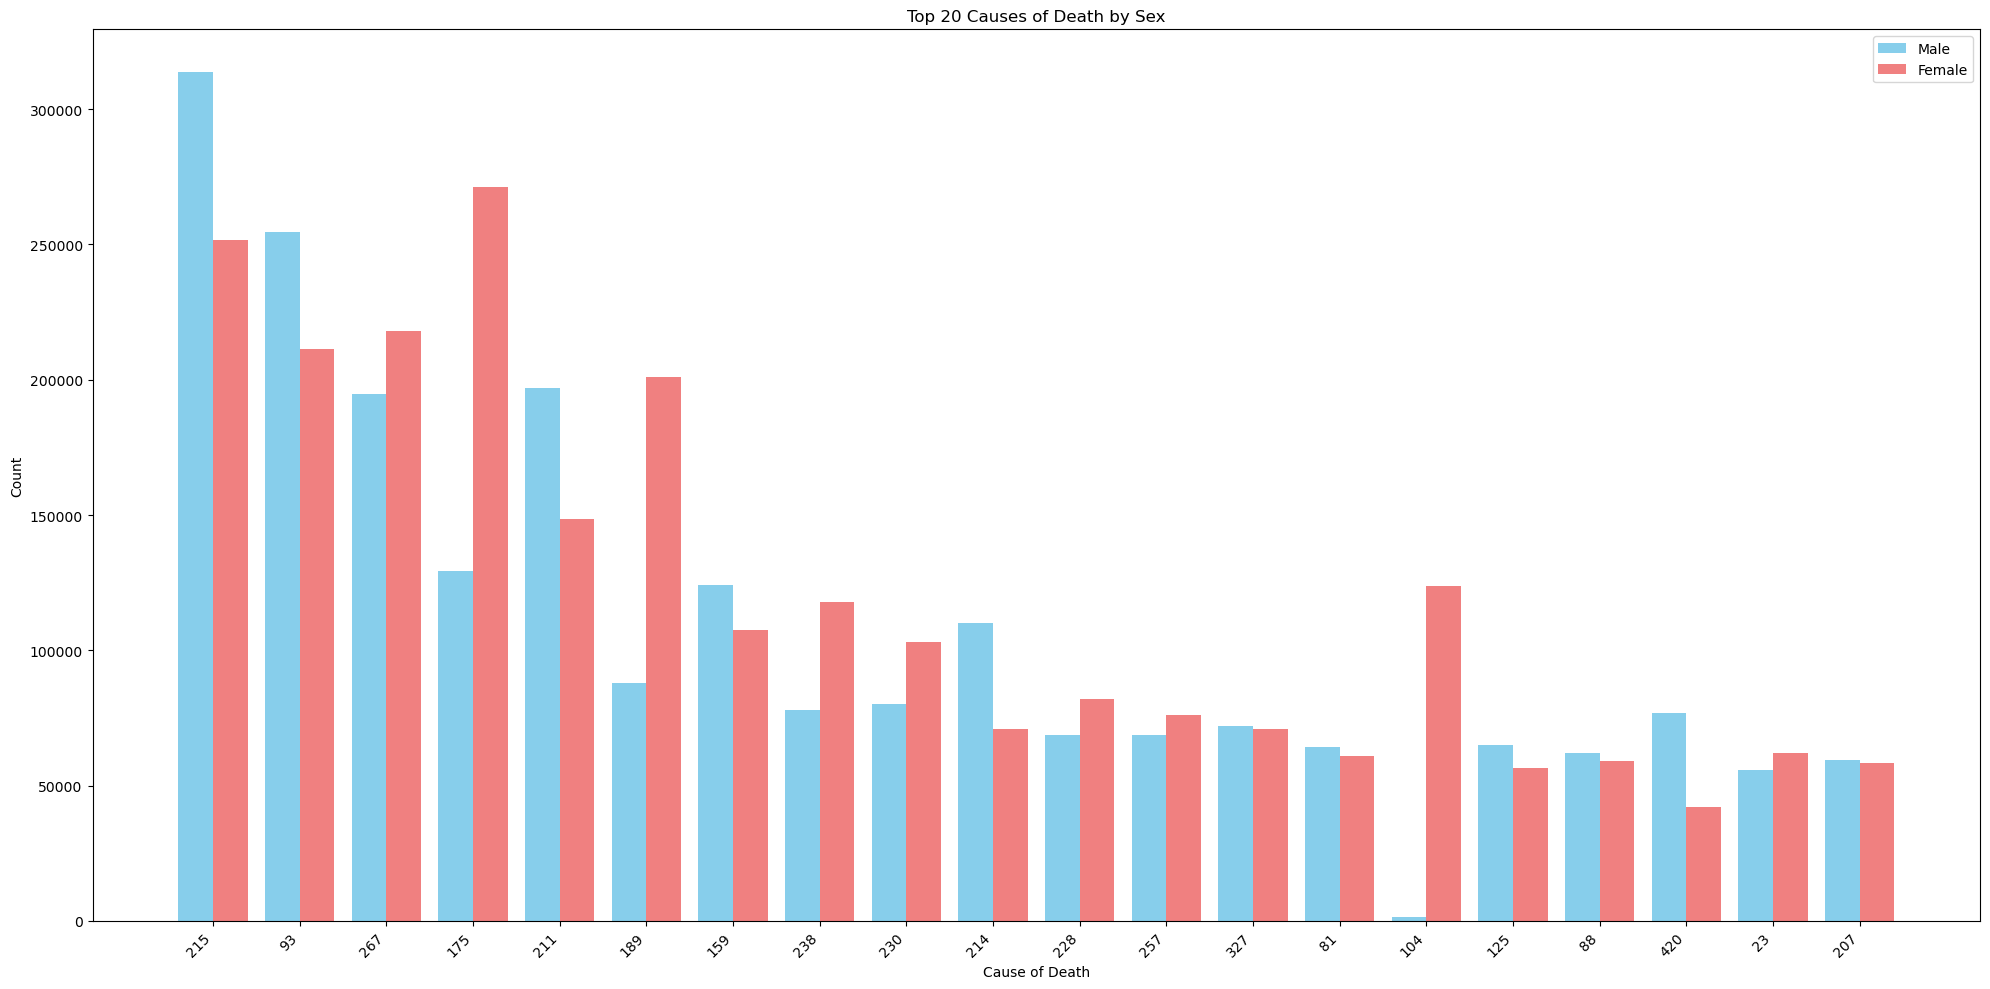

In [13]:
# Initialize dictionaries to store counts for males and females for each cause
male_counts = {cause: 0 for cause in top_causes}
female_counts = {cause: 0 for cause in top_causes}

# Iterate over the filtered causes and update counts based on sex
for row in grouped_causes_sex_filtered.collect():
    cause = row["358_cause_recode"]
    sex = row["sex"]
    count = row["count"]
    if sex == "M":
        male_counts[cause] = count
    else:
        female_counts[cause] = count

# Set up x_labels for causes and positions for plotting
x_labels = top_causes
x_positions = list(range(len(x_labels)))
bar_width = 0.4

# Extract male and female values for each cause
male_values = [male_counts.get(cause, 0) for cause in x_labels]
female_values = [female_counts.get(cause, 0) for cause in x_labels]

# Plot the bar chart comparing male and female death counts by cause
plt.figure(figsize=(20, 10))
plt.bar([x - bar_width/2 for x in x_positions], male_values, width=bar_width, label="Male", color="skyblue")
plt.bar([x + bar_width/2 for x in x_positions], female_values, width=bar_width, label="Female", color="lightcoral")

# Add labels, title, and legend
plt.xlabel("Cause of Death")
plt.ylabel("Count")
plt.title("Top 20 Causes of Death by Sex")
plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Data Preprocessing

In [14]:
# Create one-hot encoded columns for "sex" (male and female)
df_encoded = df_maped.withColumn("sex_male", when(col("sex") == "M", 1).otherwise(0)) \
               .withColumn("sex_female", when(col("sex") == "F", 1).otherwise(0))

# Print the names of the newly added one-hot encoded columns
print(f"One-Hot Columns: {df_encoded.columns[-2:]}")

One-Hot Columns: ['sex_male', 'sex_female']


In [15]:
# Identify columns with string data type and drop them from the DataFrame
string_cols = [field.name for field in df_encoded.schema.fields if isinstance(field.dataType, StringType)]

# Drop the identified string columns
df_no_strings = df_encoded.drop(*string_cols)

# Print the names of the dropped string columns
print("Dropped string columns:", string_cols)

Dropped string columns: ['sex', 'marital_status', 'injury_at_work', 'method_of_disposition', 'autopsy', 'icd_code_10th_revision', 'entity_condition_1', 'entity_condition_2', 'entity_condition_3', 'entity_condition_4', 'entity_condition_5', 'entity_condition_6', 'entity_condition_7', 'entity_condition_8', 'entity_condition_9', 'entity_condition_10', 'entity_condition_11', 'entity_condition_12', 'entity_condition_13', 'entity_condition_14', 'entity_condition_15', 'entity_condition_16', 'entity_condition_17', 'entity_condition_18', 'entity_condition_19', 'entity_condition_20', 'record_condition_1', 'record_condition_2', 'record_condition_3', 'record_condition_4', 'record_condition_5', 'record_condition_6', 'record_condition_7', 'record_condition_8', 'record_condition_9', 'record_condition_10', 'record_condition_11', 'record_condition_12', 'record_condition_13', 'record_condition_14', 'record_condition_15', 'record_condition_16', 'record_condition_17', 'record_condition_18', 'record_condit

In [16]:
# Print the schema of the DataFrame after dropping the string columns
df_no_strings.printSchema()

root
 |-- resident_status: integer (nullable = true)
 |-- education_1989_revision: integer (nullable = true)
 |-- education_2003_revision: integer (nullable = true)
 |-- education_reporting_flag: integer (nullable = true)
 |-- month_of_death: integer (nullable = true)
 |-- detail_age_type: integer (nullable = true)
 |-- detail_age: integer (nullable = true)
 |-- age_substitution_flag: integer (nullable = true)
 |-- age_recode_52: integer (nullable = true)
 |-- age_recode_27: integer (nullable = true)
 |-- age_recode_12: integer (nullable = true)
 |-- infant_age_recode_22: integer (nullable = true)
 |-- place_of_death_and_decedents_status: integer (nullable = true)
 |-- day_of_week_of_death: integer (nullable = true)
 |-- current_data_year: integer (nullable = true)
 |-- manner_of_death: integer (nullable = true)
 |-- activity_code: integer (nullable = true)
 |-- place_of_injury_for_causes_w00_y34_except_y06_and_y07_: integer (nullable = true)
 |-- 358_cause_recode: integer (nullable = 

In [17]:
# Calculate the number of null values for each column in the DataFrame
null_counts = df_no_strings.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df_no_strings.columns
])

# Convert the result to a dictionary for easy manipulation
null_counts = null_counts.first().asDict()

# Sort the columns by the number of nulls in descending order
top_nulls = sorted(null_counts.items(), key=lambda x: x[1], reverse=True)[:]

# Print columns with null values and their counts
for col_name, count in top_nulls:
    if count > 0:
        print(f"{col_name}: {count} nulls")

age_substitution_flag: 7950756 nulls
bridged_race_flag: 7917370 nulls
infant_age_recode_22: 7880508 nulls
130_infant_cause_recode: 7880508 nulls
race_imputation_flag: 7878228 nulls
place_of_injury_for_causes_w00_y34_except_y06_and_y07_: 7360349 nulls
activity_code: 7346383 nulls
education_1989_revision: 7242879 nulls
manner_of_death: 1182511 nulls
education_2003_revision: 707942 nulls


In [18]:
# Drop specific columns from the DataFrame
df_no_nulls = df_no_strings.drop("age_substitution_flag", "bridged_race_flag", "race_imputation_flag", 
                                 "place_of_injury_for_causes_w00_y34_except_y06_and_y07_", "activity_code", 
                                 "education_1989_revision", "current_data_year")

# Fill missing values for specified columns with provided default values
df_filled = df_no_nulls.fillna({"manner_of_death": 8, "education_2003_revision": 9, 
                                "infant_age_recode_22": 23, "130_infant_cause_recode": 159})

In [19]:
# Calculate the number of null values for each column in the filled DataFrame
null_counts = df_filled.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df_filled.columns
])

# Convert the result to a dictionary for easier manipulation
null_counts = null_counts.first().asDict()

# Sort the columns by the number of nulls in descending order
top_nulls = sorted(null_counts.items(), key=lambda x: x[1], reverse=True)[:]

# Print columns with null values and their counts
for col_name, count in top_nulls:
    print(f"{col_name}: {count} nulls")

resident_status: 0 nulls
education_2003_revision: 0 nulls
education_reporting_flag: 0 nulls
month_of_death: 0 nulls
detail_age_type: 0 nulls
detail_age: 0 nulls
age_recode_52: 0 nulls
age_recode_27: 0 nulls
age_recode_12: 0 nulls
infant_age_recode_22: 0 nulls
place_of_death_and_decedents_status: 0 nulls
day_of_week_of_death: 0 nulls
manner_of_death: 0 nulls
358_cause_recode: 0 nulls
113_cause_recode: 0 nulls
130_infant_cause_recode: 0 nulls
39_cause_recode: 0 nulls
number_of_entity_axis_conditions: 0 nulls
number_of_record_axis_conditions: 0 nulls
race: 0 nulls
race_recode_3: 0 nulls
race_recode_5: 0 nulls
hispanic_origin: 0 nulls
hispanic_originrace_recode: 0 nulls
sex_male: 0 nulls
sex_female: 0 nulls


In [20]:
# Filter the DataFrame to include only rows where "detail_age" is less than or equal to 126
df_filtered = df_filled.filter(df_filled["detail_age"] <= 126)

# Split the Data and Train the Model

In [21]:
# Define the label column and feature columns
label_col = "detail_age"
feature_cols = [col for col in df_filtered.columns if col != label_col]

# Create a VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

# Standardize features by scaling them to have mean 0 and standard deviation 1
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

# Define a Linear Regression model and a Random Forest Regressor model with 10 trees
lr = LinearRegression(featuresCol="features", labelCol=label_col)
rf = RandomForestRegressor(featuresCol="features", labelCol=label_col, numTrees=10)

# Create pipelines for Linear Regression and Random Forest Regressor
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data into training (80%) and test (20%) sets
train_data, test_data = df_filtered.randomSplit([0.8, 0.2], seed=42)

# Fit models to the training data
lr_model = lr_pipeline.fit(train_data)
rf_model = rf_pipeline.fit(train_data)

# Predictions and Evaluation

In [22]:
# Make predictions on the test data using the trained models
lr_preds = lr_model.transform(test_data)
rf_preds = rf_model.transform(test_data)

In [23]:
# Function to evaluate model performance using RMSE, MAE, and R2 metrics
def evaluate_model(predictions, label_col):
    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")

    # Return the evaluation metrics for the model
    return {
        "RMSE": evaluator_rmse.evaluate(predictions),
        "MAE": evaluator_mae.evaluate(predictions),
        "R2": evaluator_r2.evaluate(predictions),
    }

# Evaluate the Linear Regression model and Random Forest model
lr_metrics = evaluate_model(lr_preds, label_col)
rf_metrics = evaluate_model(rf_preds, label_col)

In [24]:
# Print the evaluation metrics for the Linear Regression model and the Random Forest model
print("Linear Regression:")
for metric, value in lr_metrics.items():
    print(f"  {metric}: {value:.2f}")

print("\nRandom Forest Regression:")
for metric, value in rf_metrics.items():
    print(f"  {metric}: {value:.2f}")

Linear Regression:
  RMSE: 1.74
  MAE: 1.29
  R2: 0.99

Random Forest Regression:
  RMSE: 2.17
  MAE: 1.56
  R2: 0.99


In [25]:
# Extract the actual values and predicted values for Linear Regression from the test data
lr_actual = test_data.select(label_col).rdd.flatMap(lambda x: x).collect()
lr_predicted = lr_preds.select("prediction").rdd.flatMap(lambda x: x).collect()

# Extract the actual values and predicted for Random Forest from the test data
rf_actual = test_data.select(label_col).rdd.flatMap(lambda x: x).collect()
rf_predicted = rf_preds.select("prediction").rdd.flatMap(lambda x: x).collect()

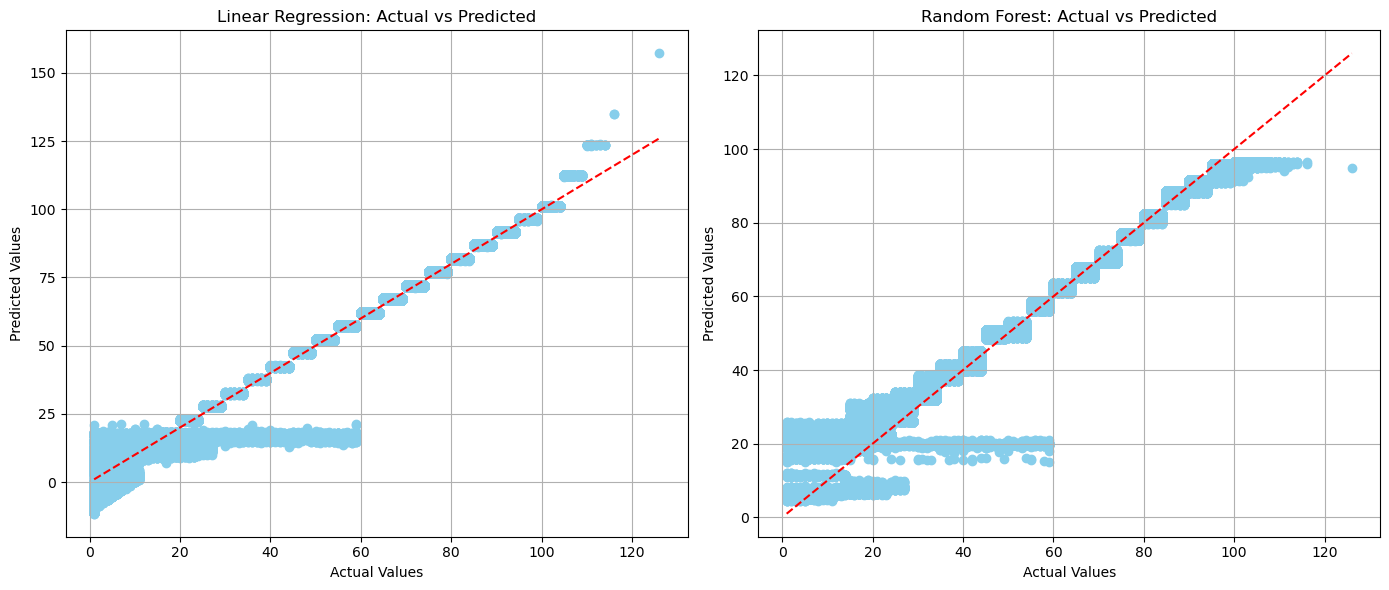

In [26]:
# Create a figure with two subplots to compare actual vs predicted values for both models
plt.figure(figsize=(14, 6))

# Subplot 1: Linear Regression Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(lr_actual, lr_predicted, color="skyblue")
plt.plot([min(lr_actual), max(lr_actual)], [min(lr_actual), max(lr_actual)], color="red", linestyle="--")  # Diagonal line (ideal prediction)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)

# Subplot 2: Random Forest Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(rf_actual, rf_predicted, color="skyblue")
plt.plot([min(rf_actual), max(rf_actual)], [min(rf_actual), max(rf_actual)], color="red", linestyle="--")  # Diagonal line (ideal prediction)
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

## Testing Prediction Without Recode Columns

In [27]:
# Drop specific columns from the DataFrame
df_filtered2 = df_filtered.drop("age_recode_52", "age_recode_27", "age_recode_12", "infant_age_recode_22")

In [28]:
# Define the new feature columns (excluding "detail_age" as the label)
feature_cols2 = [col for col in df_filtered2.columns if col != "detail_age"]

# Create a new VectorAssembler to combine features into a single vector column
assembler2 = VectorAssembler(inputCols=feature_cols2, outputCol="features_raw")

# Standardize the new features by scaling them to have mean 0 and standard deviation 1
scaler2 = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

# Define a new Linear Regression model and a new Random Forest Regressor model with 10 trees
lr2 = LinearRegression(featuresCol="features", labelCol=label_col)
rf2 = RandomForestRegressor(featuresCol="features", labelCol=label_col, numTrees=10)

# Create a new pipelines for Linear Regression and Random Forest Regressor
lr_pipeline2 = Pipeline(stages=[assembler2, scaler2, lr2])
rf_pipeline2 = Pipeline(stages=[assembler2, scaler2, rf2])

# Split the new data into training (80%) and test (20%) sets
train_data2, test_data2 = df_filtered2.randomSplit([0.8, 0.2], seed=42)

# Fit models to the new training data
lr_model2 = lr_pipeline2.fit(train_data2)
rf_model2 = rf_pipeline2.fit(train_data2)

In [29]:
# Make predictions on the test data using the trained Linear Regression model and Random Forest model
lr_preds2 = lr_model2.transform(test_data2)
rf_preds2 = rf_model2.transform(test_data2)

In [30]:
# Evaluate the new performance of the Linear Regression model on the test data
lr_metrics2 = evaluate_model(lr_preds2, label_col)
rf_metrics2 = evaluate_model(rf_preds2, label_col)

In [31]:
# Print the evaluation metrics for the Linear Regression model and the Random Forest model
print("Linear Regression:")
for metric, value in lr_metrics2.items():
    print(f"  {metric}: {value:.2f}")

print("\nRandom Forest Regression:")
for metric, value in rf_metrics2.items():
    print(f"  {metric}: {value:.2f}")

Linear Regression:
  RMSE: 15.06
  MAE: 11.80
  R2: 0.30

Random Forest Regression:
  RMSE: 14.33
  MAE: 11.26
  R2: 0.37


In [32]:
# Extract the predicted values from the Linear Regression model and the Random Forest model predictions
lr_predicted2 = lr_preds2.select("prediction").rdd.flatMap(lambda x: x).collect()
rf_predicted2 = rf_preds2.select("prediction").rdd.flatMap(lambda x: x).collect()

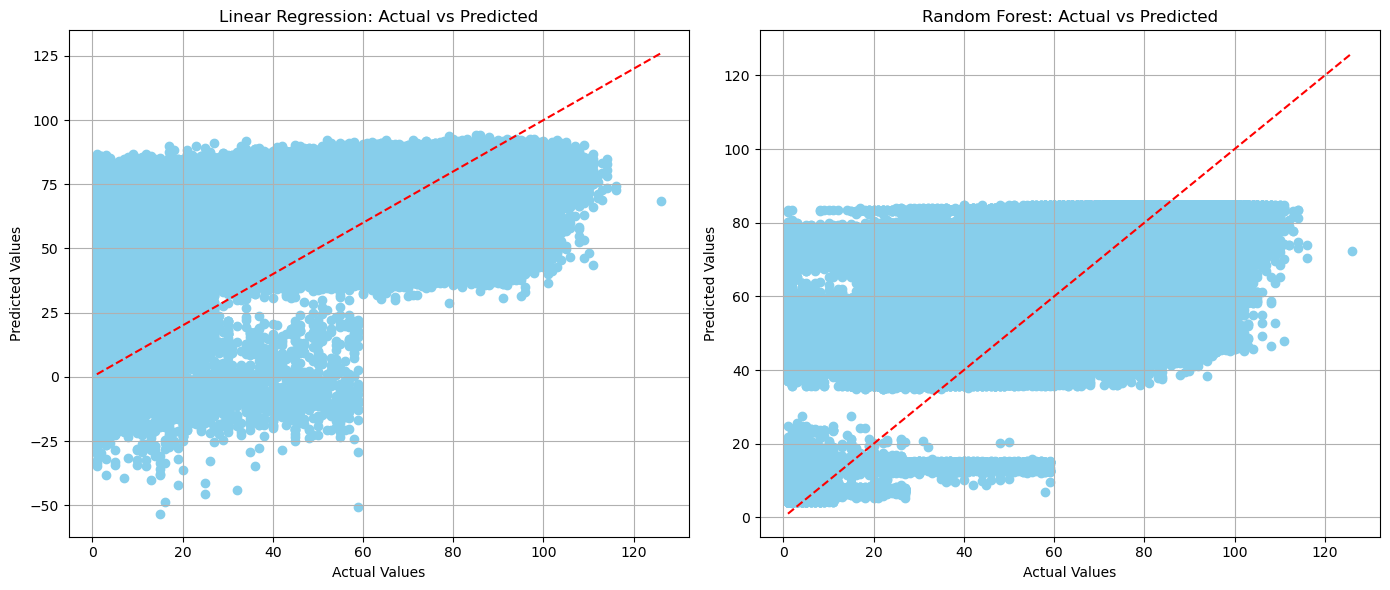

In [33]:
# Create a figure with two subplots to compare actual vs predicted values for both models
plt.figure(figsize=(14, 6))

# Subplot 1: Linear Regression Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(lr_actual, lr_predicted2, color="skyblue")
plt.plot([min(lr_actual), max(lr_actual)], [min(lr_actual), max(lr_actual)], color="red", linestyle="--")  # Diagonal line (ideal prediction)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)

# Subplot 2: Random Forest Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(rf_actual, rf_predicted2, color="skyblue")
plt.plot([min(rf_actual), max(rf_actual)], [min(rf_actual), max(rf_actual)], color="red", linestyle="--")  # Diagonal line (ideal prediction)
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()